In [1]:
!pip install librosa torch torchvision numpy matplotlib

   ---------------------------------------- 0.0/203.0 MB ? eta -:--:--
   ---------------------------------------- 0.8/203.0 MB 5.6 MB/s eta 0:00:37
   ---------------------------------------- 1.8/203.0 MB 4.8 MB/s eta 0:00:42
    --------------------------------------- 2.9/203.0 MB 4.8 MB/s eta 0:00:42
    --------------------------------------- 3.9/203.0 MB 4.9 MB/s eta 0:00:41
    --------------------------------------- 5.0/203.0 MB 4.9 MB/s eta 0:00:41
   - -------------------------------------- 6.0/203.0 MB 4.9 MB/s eta 0:00:41
   - -------------------------------------- 7.1/203.0 MB 4.8 MB/s eta 0:00:41
   - -------------------------------------- 7.9/203.0 MB 4.7 MB/s eta 0:00:42
   - -------------------------------------- 8.9/203.0 MB 4.7 MB/s eta 0:00:42
   - -------------------------------------- 10.0/203.0 MB 4.7 MB/s eta 0:00:41
   -- ------------------------------------- 11.0/203.0 MB 4.7 MB/s eta 0:00:41
   -- ------------------------------------- 12.1/203.0 MB 4.8 MB/s et


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


   -------------- ------------------------- 73.7/203.0 MB 4.7 MB/s eta 0:00:28
   -------------- ------------------------- 74.4/203.0 MB 4.7 MB/s eta 0:00:28
   -------------- ------------------------- 75.5/203.0 MB 4.7 MB/s eta 0:00:27
   --------------- ------------------------ 76.5/203.0 MB 4.7 MB/s eta 0:00:27
   --------------- ------------------------ 77.6/203.0 MB 4.7 MB/s eta 0:00:27
   --------------- ------------------------ 78.6/203.0 MB 4.7 MB/s eta 0:00:27
   --------------- ------------------------ 79.7/203.0 MB 4.7 MB/s eta 0:00:27
   --------------- ------------------------ 80.7/203.0 MB 4.7 MB/s eta 0:00:26
   ---------------- ----------------------- 81.5/203.0 MB 4.7 MB/s eta 0:00:26
   ---------------- ----------------------- 82.6/203.0 MB 4.7 MB/s eta 0:00:26
   ---------------- ----------------------- 83.6/203.0 MB 4.7 MB/s eta 0:00:26
   ---------------- ----------------------- 84.7/203.0 MB 4.7 MB/s eta 0:00:25
   ---------------- ----------------------- 85.7/203

In [13]:
import os
import librosa
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Parameters
SAMPLE_RATE = 22050    # Sample rate for audio
N_MELS = 64            # Number of Mel bands in spectrogram
AUDIO_LENGTH = 2.0     # Length of each audio sample in seconds
BATCH_SIZE = 32        # Batch size for training
DATA_DIR = "data"      # Parent directory containing 'clear' and 'wheeze' folders

# Data augmentation transformations
def audio_augmentations(audio):
    noise = np.random.randn(len(audio))
    audio = audio + 0.005 * noise  # Adding Gaussian noise as an augmentation
    return audio

# Convert audio to Mel spectrogram
def audio_to_melspectrogram(audio, sr=SAMPLE_RATE, n_mels=N_MELS):
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mel_spectrogram

# Dataset Class
class WheezeDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.file_paths = []
        self.labels = []
        for label, folder_name in enumerate(['clear', 'wheeze']):
            folder_path = os.path.join(data_dir, folder_name)
            for file_name in os.listdir(folder_path):
                self.file_paths.append(os.path.join(folder_path, file_name))
                self.labels.append(label)
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        audio, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=AUDIO_LENGTH)
        mel_spec = audio_to_melspectrogram(audio)
        mel_spec = torch.tensor(mel_spec, dtype=torch.float32)

        # Create an augmented version for contrastive learning
        aug_audio = audio_augmentations(audio)
        aug_mel_spec = audio_to_melspectrogram(aug_audio)
        aug_mel_spec = torch.tensor(aug_mel_spec, dtype=torch.float32)

        label = self.labels[idx]
        return mel_spec.unsqueeze(0), aug_mel_spec.unsqueeze(0), label

# Load dataset and create dataloader
dataset = WheezeDataset(DATA_DIR)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


In [15]:
import torch
import torch.nn as nn

class SimCLRModel(nn.Module):
    def __init__(self):
        super(SimCLRModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )

        # Dynamically determine the flattened output size of the encoder
        dummy_input = torch.randn(1, 1, N_MELS, int(SAMPLE_RATE * AUDIO_LENGTH / 512))
        with torch.no_grad():
            dummy_output = self.encoder(dummy_input)
            flattened_size = dummy_output.shape[1]

        # Use the dynamically calculated flattened size for the first linear layer
        self.fc = nn.Linear(flattened_size, 128)

    def forward(self, x):
        x = self.encoder(x)
        return self.fc(x)


def contrastive_loss(features, temperature=0.5):
    labels = torch.cat([torch.arange(features.shape[0]//2) for i in range(2)], dim=0)
    labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()
    features = nn.functional.normalize(features, dim=1)
    similarity_matrix = torch.matmul(features, features.T) / temperature
    loss = -torch.log(similarity_matrix.softmax(dim=1) + 1e-6)
    loss = loss.mean()
    return loss

# Initialize model and optimizer
model = SimCLRModel()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training Loop for Self-Supervised Learning
for epoch in range(10):
    total_loss = 0
    for x1, x2, _ in dataloader:
        optimizer.zero_grad()
        z1 = model(x1)
        z2 = model(x2)
        loss = contrastive_loss(torch.cat([z1, z2], dim=0))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/10], Loss: {total_loss/len(dataloader)}")


Epoch [1/10], Loss: 4.028864562511444
Epoch [2/10], Loss: 4.028857529163361
Epoch [3/10], Loss: 4.028857469558716
Epoch [4/10], Loss: 4.028857380151749
Epoch [5/10], Loss: 4.028857335448265
Epoch [6/10], Loss: 4.028857409954071
Epoch [7/10], Loss: 4.028857409954071
Epoch [8/10], Loss: 4.028857380151749
Epoch [9/10], Loss: 4.028857409954071
Epoch [10/10], Loss: 4.028857409954071


In [17]:
import torch
import torch.nn as nn

class FineTuneModel(nn.Module):
    def __init__(self, encoder):
        super(FineTuneModel, self).__init__()
        self.encoder = encoder
        
        # Freeze encoder weights if needed
        for param in self.encoder.parameters():
            param.requires_grad = False
        
        # Determine the flattened size of encoder output dynamically
        dummy_input = torch.randn(1, 1, N_MELS, int(SAMPLE_RATE * AUDIO_LENGTH / 512))
        with torch.no_grad():
            dummy_output = self.encoder(dummy_input)
            flattened_size = dummy_output.shape[1]
        
        # Define classifier with dynamically determined input size
        self.classifier = nn.Sequential(
            nn.Linear(flattened_size, 128),
            nn.ReLU(),
            nn.Linear(128, 2)  # Assuming binary classification (clear vs. wheeze)
        )

    def forward(self, x):
        x = self.encoder(x)
        return self.classifier(x)


# Initialize fine-tuning model and optimizer
fine_tune_model = FineTuneModel(model.encoder)
fine_tune_optimizer = optim.Adam(fine_tune_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Fine-tuning loop
for epoch in range(10):
    total_loss = 0
    for x, _, y in dataloader:
        fine_tune_optimizer.zero_grad()
        output = fine_tune_model(x)
        loss = criterion(output, y)
        loss.backward()
        fine_tune_optimizer.step()
        total_loss += loss.item()

    print(f"Fine-tuning Epoch [{epoch+1}/10], Loss: {total_loss/len(dataloader)}")


Fine-tuning Epoch [1/10], Loss: 49.854510612785816
Fine-tuning Epoch [2/10], Loss: 0.7424476556479931
Fine-tuning Epoch [3/10], Loss: 0.7056598961353302
Fine-tuning Epoch [4/10], Loss: 0.7030474208295345
Fine-tuning Epoch [5/10], Loss: 0.7021159119904041
Fine-tuning Epoch [6/10], Loss: 0.7011055313050747
Fine-tuning Epoch [7/10], Loss: 0.7013495862483978
Fine-tuning Epoch [8/10], Loss: 0.6990611329674721
Fine-tuning Epoch [9/10], Loss: 0.6988294161856174
Fine-tuning Epoch [10/10], Loss: 0.6963772438466549


Accuracy: 0.4380
Precision: 0.4380
Recall: 1.0000
F1 Score: 0.6092
ROC-AUC: 0.5000
PR-AUC: 0.7190
Confusion Matrix:
[[  0 272]
 [  0 212]]


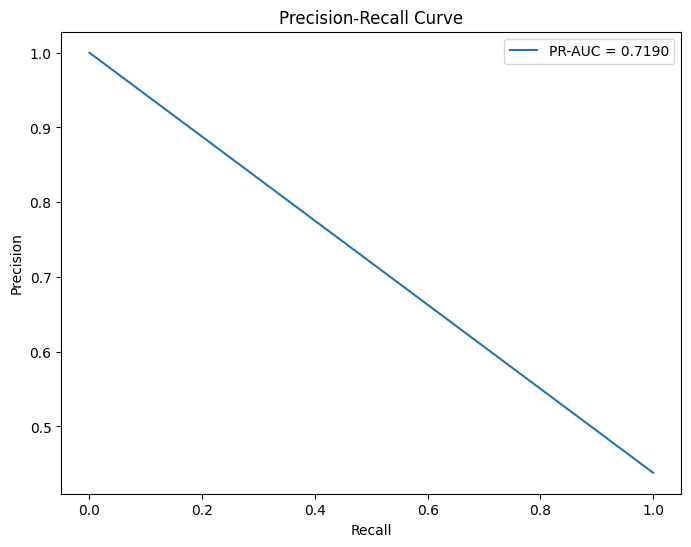

In [20]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Define the evaluation dataset (use the same WheezeDataset or a separate test dataset)
class WheezeDatasetTest(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.file_paths = []
        self.labels = []
        for label, folder_name in enumerate(['clear', 'wheeze']):
            folder_path = os.path.join(data_dir, folder_name)
            for file_name in os.listdir(folder_path):
                self.file_paths.append(os.path.join(folder_path, file_name))
                self.labels.append(label)
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        audio, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=AUDIO_LENGTH)
        mel_spec = audio_to_melspectrogram(audio)
        mel_spec = torch.tensor(mel_spec, dtype=torch.float32)
        label = self.labels[idx]
        return mel_spec.unsqueeze(0), label

# Assuming you have a separate test directory or dataset for evaluation
test_dataset = WheezeDatasetTest(DATA_DIR)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define a function to calculate metrics
def evaluate(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    
    # Lists to store true labels and predictions
    true_labels = []
    predicted_labels = []
    probabilities = []

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            
            # Get model outputs
            output = model(x)
            
            # Predicted class labels
            _, preds = torch.max(output, 1)
            
            # Predicted probabilities for the positive class ("wheeze")
            probs = torch.softmax(output, dim=1)[:, 1]  # Assuming class 1 is "wheeze"
            
            # Store predictions and true labels
            true_labels.extend(y.cpu().numpy())
            predicted_labels.extend(preds.cpu().numpy())
            probabilities.extend(probs.cpu().numpy())

    # Convert lists to numpy arrays
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)
    probabilities = np.array(probabilities)

    # Compute evaluation metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, pos_label=1)
    recall = recall_score(true_labels, predicted_labels, pos_label=1)
    f1 = f1_score(true_labels, predicted_labels, pos_label=1)
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # ROC-AUC Score
    roc_auc = roc_auc_score(true_labels, probabilities)

    # Precision-Recall Curve and PR-AUC
    precision_vals, recall_vals, _ = precision_recall_curve(true_labels, probabilities)
    pr_auc = auc(recall_vals, precision_vals)

    # Print the results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"PR-AUC: {pr_auc:.4f}")
    print(f"Confusion Matrix:\n{conf_matrix}")

    # Plot Precision-Recall Curve (Optional for better understanding)
    plt.figure(figsize=(8, 6))
    plt.plot(recall_vals, precision_vals, label=f'PR-AUC = {pr_auc:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.show()

# Now, evaluate the fine-tuned model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
fine_tune_model.to(device)

evaluate(fine_tune_model, test_dataloader, device)
